In [1]:
import pandas as pd 
import numpy as np
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("C:\\Users\\norma\\OneDrive\\Desktop\\NOVICHOK\\novichok_356_cross_validation\\data\\csv\\dataset_no_imaginary.csv",delimiter=",",encoding="utf-8")

In [3]:
# Создал функцию, которая проходит по директории и читает наши '.xyz'-файлы
# Название каждого файла в моей директории отражено в датасете в столбце 'name' без расширения .xyz 
# Сконвертировал координаты в numpy-массив и закинул в новый столбец 'coordinates' в датасете

coordinates_list = []

def read_xyz_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[2:] 
        coordinates = []
        for line in lines:
            parts = line.split()
            if len(parts) == 4: 
                coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])
        return np.array(coordinates)

for index, row in data.iterrows():
    file_name = str(row['name']) + ".xyz"
    file_path = os.path.join("C:\\Users\\norma\\OneDrive\\Desktop\\NOVICHOK\\novichok_356_cross_validation\\xyz", file_name)
    coordinates = read_xyz_file(file_path)
    coordinates_list.append(coordinates)
data['coordinates'] = coordinates_list

In [4]:
data

,name,hf_gibbs_free_energy_ev,hf_electronic_energy_ev,hf_entropy_ev,hf_enthalpy_ev,hf_dipole_moment,hf_homo_ev,hf_lumo_ev,dft_gibbs_free_energy_ev,dft_electronic_energy_ev,dft_entropy_ev,dft_enthalpy_ev,dft_dipole_moment,dft_homo_ev,dft_lumo_ev,coordinates
0,002-M-BA1-b,-27275.076351,-27281.888683,1.795316,-27273.281035,0.87236,-8.8130,4.0489,-27617.108248,-27623.000160,1.877779,-27615.230469,1.47466,-6.2925,-1.4983,"[[-3.6610385002265, 6.93533048376608, -0.58345..."
1,002-M-BA1-pipi,-27275.128802,-27281.952769,1.772166,-27273.356635,1.19181,-9.2580,4.4306,-27617.107555,-27623.063060,1.822257,-27615.285298,1.69901,-6.7665,-1.3131,"[[-3.24946263013423, 6.99473259895769, -1.4223..."
2,005-MEL-CA,-25599.449771,-25604.305425,1.564143,-25597.885628,0.93514,-8.9909,4.6443,-25917.872472,-25922.091294,1.641525,-25916.230947,0.85984,-6.4902,-0.8343,"[[-5.415595, -7.691943, 0.824725], [-4.323509,..."
3,006-MEL-UA,-29133.284441,-29138.979188,1.668533,-29131.615908,2.68196,-8.2371,3.9070,-29496.320185,-29501.224258,1.791889,-29494.528296,3.15832,-6.1902,-1.1975,"[[-5.251705, -7.658659, 1.031666], [-4.20755, ..."
4,007-MEL-CR,-22635.215921,-22641.289493,1.651416,-22633.564505,6.85797,-8.6600,5.1451,-22922.502813,-22927.782911,1.687934,-22920.814880,6.66567,-6.3708,-0.2151,"[[-5.271343, -7.699293, 0.886577], [-4.227247,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,dimer_006121,-19613.756532,-19622.869155,1.793542,-19611.962991,6.65332,-9.2198,6.4409,-19866.663508,-19874.318183,1.856166,-19864.807342,7.42245,-6.4218,0.1743,"[[1.30646491596164, -0.57524990278906, -1.3873..."
154,dimer_006125,-20685.601738,-20693.928747,1.763538,-20683.838200,6.26955,-9.4013,4.9169,-20947.601629,-20954.521584,1.884566,-20945.717064,3.73848,-6.6824,-1.1960,"[[0.72411350301662, -0.84318903552034, 1.47813..."
155,dimer_006130,-20747.583954,-20757.490597,1.733202,-20745.850752,7.75520,-9.8085,11.3969,-21011.664617,-21019.968290,1.833384,-21009.831233,6.57082,-6.5023,0.1869,"[[-0.1568812460469, 1.12137289084067, -0.50992..."
156,dimer_006131,-22685.503101,-22693.815819,1.715946,-22683.787155,7.83449,-9.9891,11.2032,-22967.819716,-22974.854229,1.795052,-22966.024664,6.23344,-6.7157,0.1428,"[[-0.06237487272243, 0.8137375865662, -0.11994..."


In [5]:
# Для обучения использовал все дескрипторы, посчитанные на HF-3c уровне + столбец 'coordinates'  
# Первые 56 строк в документе - реальный датасет

features = ['hf_gibbs_free_energy_ev', 'hf_electronic_energy_ev', 'hf_entropy_ev',
            'hf_enthalpy_ev', 'hf_dipole_moment', 'hf_homo_ev', 'hf_lumo_ev', 'coordinates']
target = 'dft_lumo_ev'

train_data = data.iloc[18:]  
test_data = data.iloc[:18]   

In [6]:
# Скопировал сеты, т.к. предупреждение 'SettingWithCopyWarning' постоянно выскакивало при сглаживанни

X_train = train_data[features].copy()
y_train = train_data[target].copy()
X_test = test_data[features].copy()
y_test = test_data[target].copy()

In [7]:
# Сглаживание numpy-массива с координатами

X_train['coordinates'] = X_train['coordinates'].apply(np.ravel)
X_test['coordinates'] = X_test['coordinates'].apply(np.ravel)

In [8]:
# Определил максимальную длину сглаженных массивов для каждого сета
# Эта информация пригодится для дополнения сглаженных массивов, чтобы они были одинаковой длины 
# Это нужно для совместимости массива с моделями из сайкит-лерн

max_length_train = X_train['coordinates'].apply(len).max()
max_length_test = X_test['coordinates'].apply(len).max()

In [9]:
X_train['coordinates'] = X_train['coordinates'].apply(lambda x: np.pad(x, (0, max_length_train - len(x)), mode='constant'))
X_test['coordinates'] = X_test['coordinates'].apply(lambda x: np.pad(x, (0, max_length_test - len(x)), mode='constant'))

In [10]:
# Конкатенирую полученные сглаженные массивы с остальными столбцами

X_train_numeric = pd.concat([X_train.drop(columns='coordinates'),
                             pd.DataFrame(np.vstack(X_train['coordinates']), 
                                          columns=[f'coord_{i}' for i in range(max_length_train)], 
                                          index=X_train.index)],
                            axis=1)

X_test_numeric = pd.concat([X_test.drop(columns='coordinates'),
                            pd.DataFrame(np.vstack(X_test['coordinates']), 
                                         columns=[f'coord_{i}' for i in range(max_length_test)], 
                                         index=X_test.index)],
                           axis=1)

In [11]:
# Numpy-массив у тестовой выборки (реальный датасет) короче, чем у тренировочной
# Определил разницу в длинах массивов, а затем привел к общей длине

max_columns = max(X_train_numeric.shape[1], X_test_numeric.shape[1])
X_train_numeric = X_train_numeric.reindex(columns=X_train_numeric.columns.union(X_test_numeric.columns), fill_value=0)
X_test_numeric = X_test_numeric.reindex(columns=X_train_numeric.columns, fill_value=0)

In [12]:
# Нормализация тренировочного датасета
# Процедуру применил ко всем дескрипторам, кроме координат

scaler = StandardScaler()

coord_columns = [col for col in X_train_numeric.columns if col.startswith('coord_')]
non_coord_columns = [col for col in X_train_numeric.columns if col not in coord_columns]

X_train_non_coord_scaled = scaler.fit_transform(X_train_numeric[non_coord_columns])
X_train_numeric_scaled = pd.concat([pd.DataFrame(X_train_non_coord_scaled, columns=non_coord_columns, index=X_train_numeric.index),
                                    X_train_numeric[coord_columns]], axis=1)

X_test_non_coord_scaled = scaler.transform(X_test_numeric[non_coord_columns])
X_test_numeric_scaled = pd.concat([pd.DataFrame(X_test_non_coord_scaled, columns=non_coord_columns, index=X_test_numeric.index),
                                   X_test_numeric[coord_columns]], axis=1)

In [13]:
# Нормализация таргета

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [14]:
# К сожалению,ресурсов моего ПК не хватило для построения полиномов большего порядка
# Для 4-го порядка выдается ошибка, связанная с нехваткой памяти, а полином 3-го порядка считается долго

degree = 2  
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_numeric_scaled, y_train_scaled)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [15]:
# Кросс-валидация

cv_scores = cross_val_score(model, X_train_numeric_scaled, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation RMSE scores:", cv_scores)

Cross-Validation RMSE scores: [3.50312625 0.62156542 0.29811363 0.19728114 0.46693003]


In [16]:
# Оцениваю обученную модель на тестовой выборке
# Провел обратное преобразование предсказанных и тестовых значений таргета, которые ранее были нормализованы

y_pred_scaled = model.predict(X_test_numeric_scaled)

y_pred_inverse = scaler_y.inverse_transform(y_pred_scaled)
y_test_inverse = scaler_y.inverse_transform(y_test_scaled)

In [17]:
# MSE, RMSE, R^2, MAE - метрики качества

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)

print("Mean Squared Error (MSE) on test data:", mse)
print("Root Mean Squared Error (RMSE) on test data:", rmse)
print("R-squared on test data:", r_squared)
print("Mean absolute error: ", mae)

Mean Squared Error (MSE) on test data: 14.129044111994435
Root Mean Squared Error (RMSE) on test data: 3.758862076745359
R-squared on test data: -94.48052132563207
Mean absolute error:  2.5524360858871398


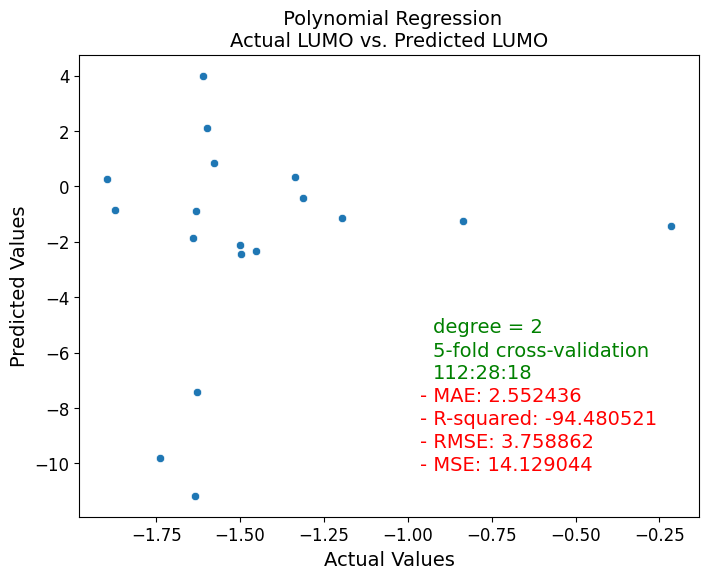

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_inverse.flatten(), y=y_pred_inverse.flatten())
#plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'k--', lw=2) 
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title(' Polynomial Regression\nActual LUMO vs. Predicted LUMO', fontsize=14)

#plt.text(0.028, 0.80, f'- MSE: {mse:.6f}\n- RMSE: {rmse:.6f}\n- R-squared: {r_squared:.6f}\n- MAE: {mae:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
#plt.text(0.050, 0.70, '5-fold cross-validation\n112:28:18', color='green', fontsize=14, ha='left', transform=plt.gca().transAxes)

plt.text(0.55, 0.1, f'- MSE: {mse:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.55, 0.15, f'- RMSE: {rmse:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.55, 0.2, f'- R-squared: {r_squared:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.55, 0.25, f'- MAE: {mae:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.57, 0.3, '5-fold cross-validation\n112:28:18', color='green', fontsize=14, ha='left', transform=plt.gca().transAxes)
plt.text(0.57, 0.4, 'degree = 2', color='green', fontsize=14, ha='left', transform=plt.gca().transAxes)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [19]:
# ТОП-5 лучших предсказанных значений и величина абсолютной разницы

y_test_flattened = y_test_inverse.flatten()
y_pred_flattened = y_pred_inverse.flatten()

comparison_df = pd.DataFrame({'Actual LUMO': y_test_flattened, 'Predicted LUMO': y_pred_flattened})
comparison_df['Absolute Difference'] = abs(comparison_df['Actual LUMO'] - comparison_df['Predicted LUMO'])

best_results = comparison_df.sort_values(by='Absolute Difference').head(5)
print("\033[1m{:^55}\033[0m".format("POLYNOMIAL REGRESSION"))
print("{:^55}".format("TOP-5 Predicted Values\n"))
print(best_results.to_string(index=False))

                 POLYNOMIAL REGRESSION                 
                TOP-5 Predicted Values
                
 Actual LUMO  Predicted LUMO  Absolute Difference
     -1.1975       -1.157606             0.039894
     -1.6393       -1.856335             0.217035
     -0.8343       -1.257971             0.423671
     -1.5003       -2.100042             0.599742
     -1.6314       -0.897800             0.733600
